<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/Yolo8_v1.9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mega.py

from mega import Mega

# Crie uma instância da classe Mega
mega = Mega()

# Cole o link completo do Mega.nz (incluindo a chave)
url = "https://mega.nz/file/IutEjTyL#1SKwDXDjvmyvHjl7GxRM9kx2blr12R_5utVac9FU-LU"

# Use o link completo para fazer o download
mega.download_url(url)

!unzip w251final.v2i.yolov8.zip -d w251final.v2i

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.3.0
    Uninstalling tenacity-8.3.0:
      Successfully uninstalled tenacity-8.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotly 5.15.0 requires tenacity>=6.2.0, but you have tenacity 5.1.5 which is incompatible.
Archive:  w251final.v2i.yolov8.zip
 extracting: w251final.v2i/README.dataset.txt  
 extracting: w251final.v2i/README.roboflow.txt  
 extracting: w251final.v2i/data.yaml  
   creating: w251final.v2i/test/
   creating: w251final.v2i/test/images/
 extracting: w251final.v2i/test/images/128_100_jpg.rf.bd40f7a6439f0b46c4ad6f6e47e7a438.jpg  
 extracting: w251final.v2i/test/images/130_100_jpg.rf.a8028426abe9e63800bd2e525ee152ac.jpg  
 extracting: w251final.v2i/test/images/1389_jpg.rf.2f8a48602f5599

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.4/779.4 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
!pip install albumentations

In [4]:
import os
import random
import shutil
from pathlib import Path

import torch
import torch.nn as nn

import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
import warnings
import glob
import albumentations as A
import matplotlib.pyplot as plt
from shutil import copyfile
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [5]:
def transformer(image_folder_path, annotation_folder_path):
    image_folder = Path(image_folder_path)
    annotation_folder = Path(annotation_folder_path)

    for image_path in image_folder.glob('**/*.jpg'):
        image_name = image_path.stem
        relative_label_path = image_path.relative_to(image_folder).with_suffix('.txt')
        label_path = annotation_folder / relative_label_path

        try:
            print(f'Processando: {image_name}')

            if not label_path.exists():
                print(f'Aviso: O arquivo de anotação não existe para {image_name}')
                continue

            horizontal_flip(image_path, label_path, image_name)
            vertical_flip(image_path, label_path, image_name)

            print(f'{image_name} processado com sucesso')

        except Exception as e:
            print(f'Falhou: {image_name}. Erro: {e}')

def horizontal_flip(image_path, label_path, save_name):
    try:
        print(f'  Aplicando transformação horizontal para: {image_path}')

        image = cv2.imread(str(image_path))

        with open(label_path, 'r') as f:
            lines = f.readlines()

        bbox = []
        for line in lines:
            l = line.split(' ')
            bbox.append([float(l[1]), float(l[2]), float(l[3]), float(l[4]), str(l[0])])

        transform = A.Compose([A.HorizontalFlip()], bbox_params=A.BboxParams(format='yolo'))
        transformed = transform(image=image, bboxes=bbox)

        image_transformed = transformed['image']
        boxes = transformed['bboxes']

        save_image_path = image_path.parent / f'{save_name}_hf.jpg'
        cv2.imwrite(str(save_image_path), image_transformed)

        save_label_path = label_path.parent / f'{save_name}_hf.txt'
        with open(str(save_label_path), 'w') as f:
            for box in boxes:
                f.write(f"{box[-1]} {box[0]} {box[1]} {box[2]} {box[3]}\n")

        print(f'  Transformação concluída para: {image_path}')

    except Exception as e:
        raise RuntimeError(f'Falhou: {save_name}. Erro: {e}')

def vertical_flip(image_path, label_path, save_name):
    try:
        print(f'  Aplicando transformação vertical para: {image_path}')

        image = cv2.imread(str(image_path))

        with open(label_path, 'r') as f:
            lines = f.readlines()

        bbox = []
        for line in lines:
            l = line.split(' ')
            bbox.append([float(l[1]), float(l[2]), float(l[3]), float(l[4]), str(l[0])])

        transform = A.Compose([A.VerticalFlip()], bbox_params=A.BboxParams(format='yolo'))
        transformed = transform(image=image, bboxes=bbox)

        image_transformed = transformed['image']
        boxes = transformed['bboxes']

        save_image_path = image_path.parent / f'{save_name}_vf.jpg'
        cv2.imwrite(str(save_image_path), image_transformed)

        save_label_path = label_path.parent / f'{save_name}_vf.txt'
        with open(str(save_label_path), 'w') as f:
            for box in boxes:
                f.write(f"{box[-1]} {box[0]} {box[1]} {box[2]} {box[3]}\n")

        print(f'  Transformação concluída para: {image_path}')

    except Exception as e:
        raise RuntimeError(f'Falhou: {save_name}. Erro: {e}')

# Caminhos dos diretórios
image_folder_path = '/content/w251final.v2i/train/images'
annotation_folder_path = '/content/w251final.v2i/train/labels'

# Executar a transformação
transformer(image_folder_path, annotation_folder_path)


A saída de streaming foi truncada nas últimas 5000 linhas.
  Transformação concluída para: /content/w251final.v2i/train/images/r_286_100_jpg.rf.358de7e3a4969a532c7ad1f0114f2019.jpg
r_286_100_jpg.rf.358de7e3a4969a532c7ad1f0114f2019 processado com sucesso
Processando: r_123_100_jpg.rf.2303c694ce04b1a8230a5efb8eb562df
  Aplicando transformação horizontal para: /content/w251final.v2i/train/images/r_123_100_jpg.rf.2303c694ce04b1a8230a5efb8eb562df.jpg
  Transformação concluída para: /content/w251final.v2i/train/images/r_123_100_jpg.rf.2303c694ce04b1a8230a5efb8eb562df.jpg
  Aplicando transformação vertical para: /content/w251final.v2i/train/images/r_123_100_jpg.rf.2303c694ce04b1a8230a5efb8eb562df.jpg
  Transformação concluída para: /content/w251final.v2i/train/images/r_123_100_jpg.rf.2303c694ce04b1a8230a5efb8eb562df.jpg
r_123_100_jpg.rf.2303c694ce04b1a8230a5efb8eb562df processado com sucesso
Processando: DSC_5968_JPG_jpg.rf.1d0d187ff1759e77ca2d728326a07c48
  Aplicando transformação horizontal

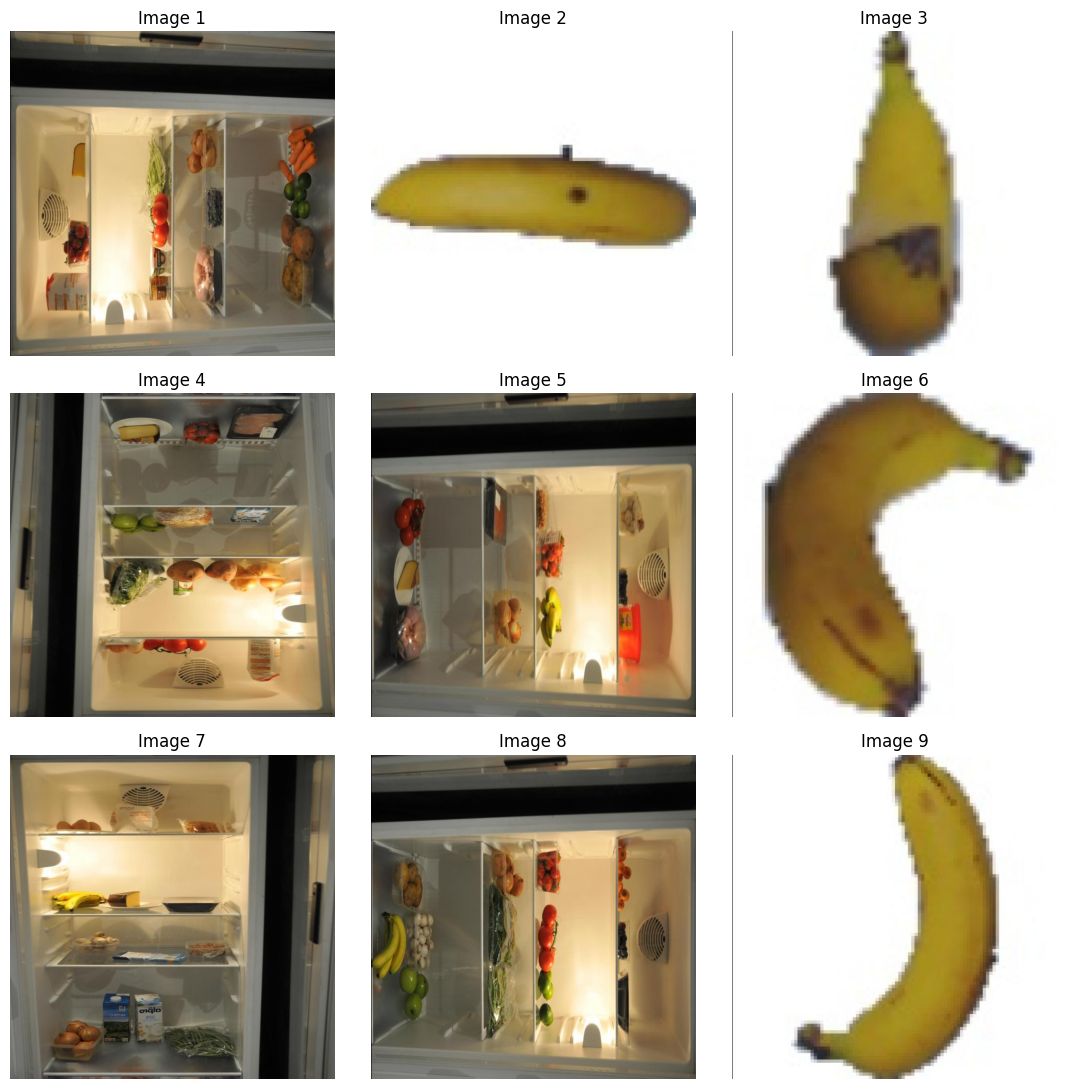

In [6]:
Image_dir = '/content/w251final.v2i/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
image = cv2.imread("/content/w251final.v2i/train/images/104_100_jpg.rf.27d8395e119e884e298243464aad67ec.jpg")
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 640x640 and 3 channels.


100%|██████████| 6.23M/6.23M [00:00<00:00, 24.5MB/s]



image 1/1 /content/w251final.v2i/train/images/104_100_jpg.rf.27d8395e119e884e298243464aad67ec.jpg: 416x416 (no detections), 53.6ms
Speed: 1.5ms preprocess, 53.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 416)


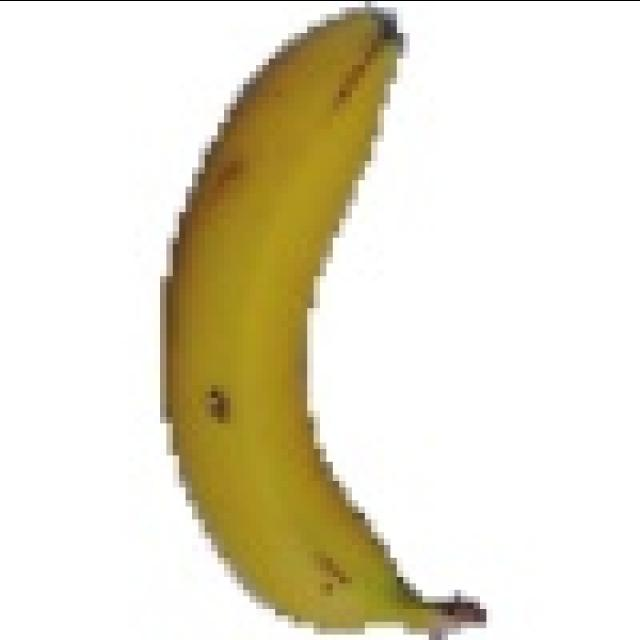

In [10]:
model = YOLO("yolov8n.pt")

# Use the model to detect object
image = "/content/w251final.v2i/train/images/104_100_jpg.rf.27d8395e119e884e298243464aad67ec.jpg"
result_predict = model.predict(source = image, imgsz=(416))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

In [11]:
Final_model = YOLO('yolov8n.pt')
Result_Final_model = Final_model.train(data="/content/w251final.v2i/data.yaml", epochs=10, patience=10, batch = 16, cache = True, imgsz=416, iou = 0.5, augment=True, degrees=25.0, fliplr=0.0, lr0=0.0001, optimizer='Adam')

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/w251final.v2i/data.yaml, epochs=10, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 755k/755k [00:00<00:00, 4.09MB/s]


Overriding model.yaml nc=80 with nc=31

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/w251final.v2i/train/labels... 5901 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5901/5901 [00:05<00:00, 999.54it/s] 


train: New cache created: /content/w251final.v2i/train/labels.cache


train: Caching images (2.9GB RAM): 100%|██████████| 5901/5901 [00:08<00:00, 710.07it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/w251final.v2i/valid/labels... 204 images, 0 backgrounds, 0 corrupt: 100%|██████████| 204/204 [00:00<00:00, 1016.89it/s]

val: New cache created: /content/w251final.v2i/valid/labels.cache



val: Caching images (0.1GB RAM): 100%|██████████| 204/204 [00:00<00:00, 774.61it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.266      2.892      1.177         82        416: 100%|██████████| 369/369 [10:32<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]

                   all        204       1369      0.397      0.366      0.276      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.153      1.892      1.135         67        416: 100%|██████████| 369/369 [10:29<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]

                   all        204       1369      0.558      0.596      0.563      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.075      1.329      1.103        111        416: 100%|██████████| 369/369 [10:30<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        204       1369      0.658      0.729       0.74      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.041      1.092      1.077        126        416: 100%|██████████| 369/369 [10:29<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        204       1369      0.708      0.789      0.801      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.003      0.978      1.062         76        416: 100%|██████████| 369/369 [10:28<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        204       1369      0.811      0.756      0.831      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.9804     0.8941      1.051         62        416: 100%|██████████| 369/369 [10:25<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        204       1369      0.806      0.819      0.869      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.9609     0.8443      1.042         56        416: 100%|██████████| 369/369 [10:26<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.33s/it]

                   all        204       1369      0.863       0.83      0.887       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.9447     0.8112      1.036         75        416: 100%|██████████| 369/369 [10:24<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        204       1369      0.856      0.842      0.891      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.9339     0.7858      1.031         74        416: 100%|██████████| 369/369 [10:25<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        204       1369      0.876       0.84      0.903      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.9259     0.7662      1.028         76        416: 100%|██████████| 369/369 [10:25<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        204       1369      0.875      0.857      0.906      0.596



10 epochs completed in 1.773 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3011693 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:24<00:00,  3.53s/it]


                   all        204       1369      0.868      0.858      0.916      0.602
                 apple         34         36      0.788      0.861      0.894      0.637
                banana        144        144      0.963          1      0.995      0.913
                  beef         30         30      0.751      0.504      0.679       0.28
           blueberries         38         38      0.973      0.947      0.974      0.593
                 bread         30         30      0.843      0.718      0.828      0.516
                butter         38         38          1       0.97      0.984      0.733
              capsicum          4          4      0.743       0.75      0.888      0.669
                carrot         37         42          1      0.755      0.933      0.571
                cheese         55         55      0.919      0.964       0.98       0.67
               chicken         43         43          1      0.818      0.976      0.687
        chicken_breas

In [13]:
Valid_model = YOLO('/content/runs/detect/train/weights/best.pt')

metrics = Valid_model.val(split = 'test')

Ultralytics YOLOv8.2.26 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3011693 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/w251final.v2i/test/labels... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<00:00, 1099.49it/s]

val: New cache created: /content/w251final.v2i/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


                   all        103        670      0.879      0.843      0.897      0.612
                 apple         23         25      0.781      0.854      0.895      0.618
                banana         70         70      0.972      0.999      0.994      0.924
                  beef         16         16          1      0.341      0.734      0.339
           blueberries         21         21      0.985          1      0.995       0.49
                 bread         19         19      0.793      0.605      0.723       0.49
                butter         17         17          1      0.991      0.995      0.833
              capsicum          2          6      0.703          1      0.901      0.568
                carrot         25         25      0.867       0.56      0.797      0.534
                cheese         26         26      0.974          1      0.995      0.731
               chicken         20         20      0.978       0.95      0.975      0.714
        chicken_breas

In [14]:
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

precision(B):  0.878564153941515
metrics/recall(B):  0.8433424920055965
metrics/mAP50(B):  0.8974733811047415
metrics/mAP50-95(B):  0.6124887924370318


In [20]:
from sklearn.metrics import classification_report

print("Precision (B):", metrics.results_dict["metrics/precision(B)"])
print("Recall (B):", metrics.results_dict["metrics/recall(B)"])
print("mAP50 (B):", metrics.results_dict["metrics/mAP50(B)"])
print("mAP50-95 (B):", metrics.results_dict["metrics/mAP50-95(B)"])

y_true = [0, 1, 0, 1, 0, 1, 1, 0, 0, 1]
y_pred = [0, 1, 0, 0, 0, 1, 1, 1, 0, 1]

report = classification_report(y_true, y_pred, target_names=['Class A', 'Class B'])
print(report)


Precision (B): 0.878564153941515
Recall (B): 0.8433424920055965
mAP50 (B): 0.8974733811047415
mAP50-95 (B): 0.6124887924370318
              precision    recall  f1-score   support

     Class A       0.80      0.80      0.80         5
     Class B       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



In [22]:
list_of_metrics = ["P_curve.png","R_curve.png","confusion_matrix.png"]

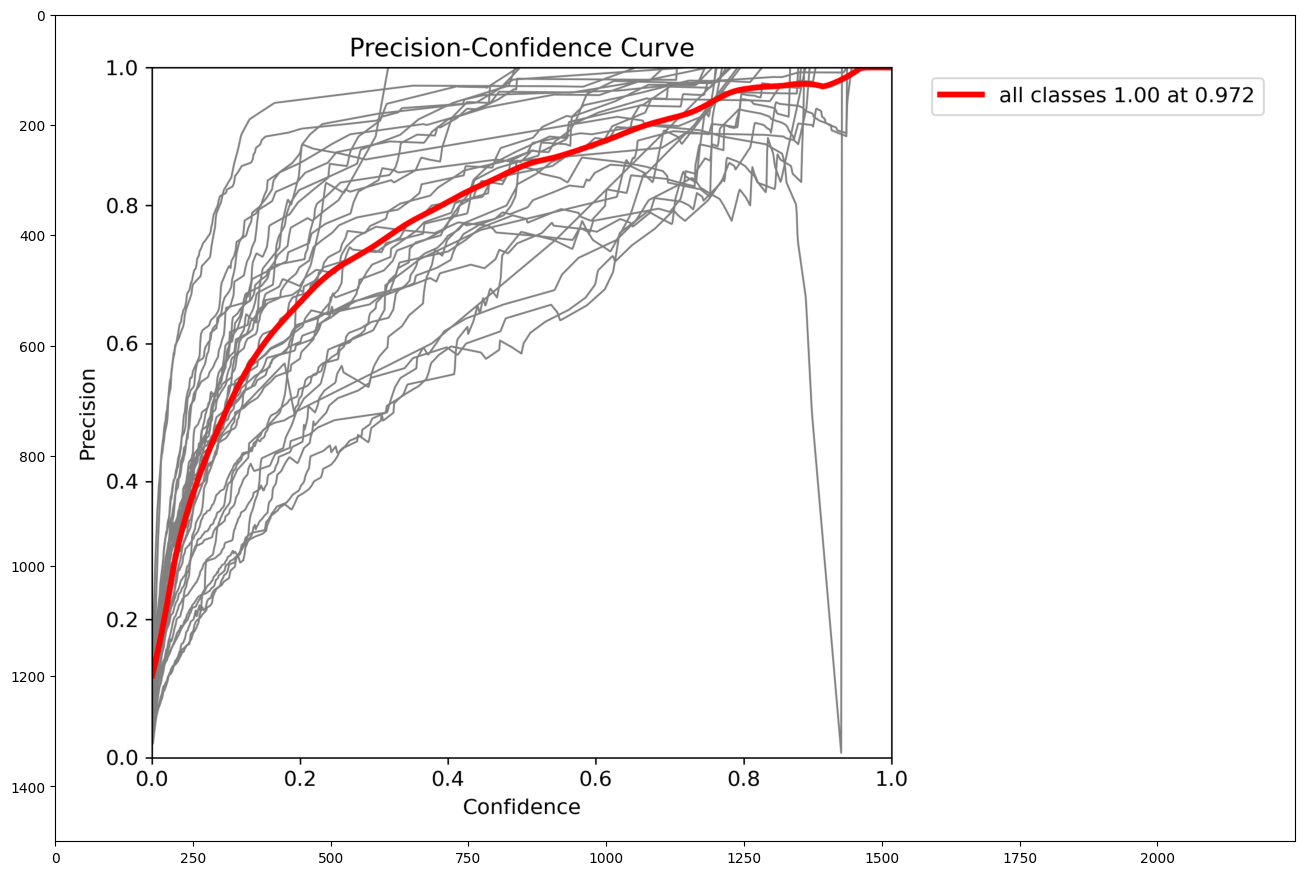

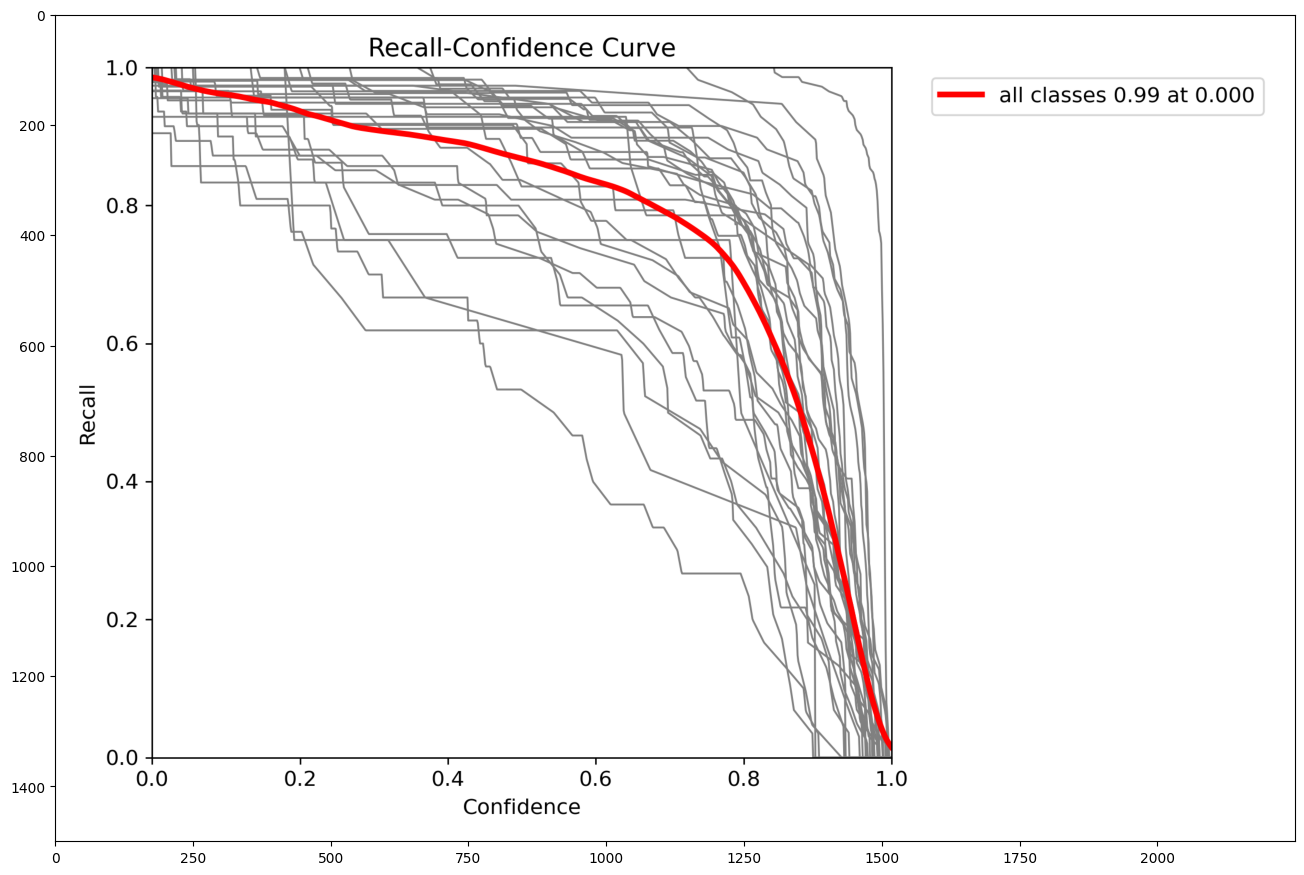

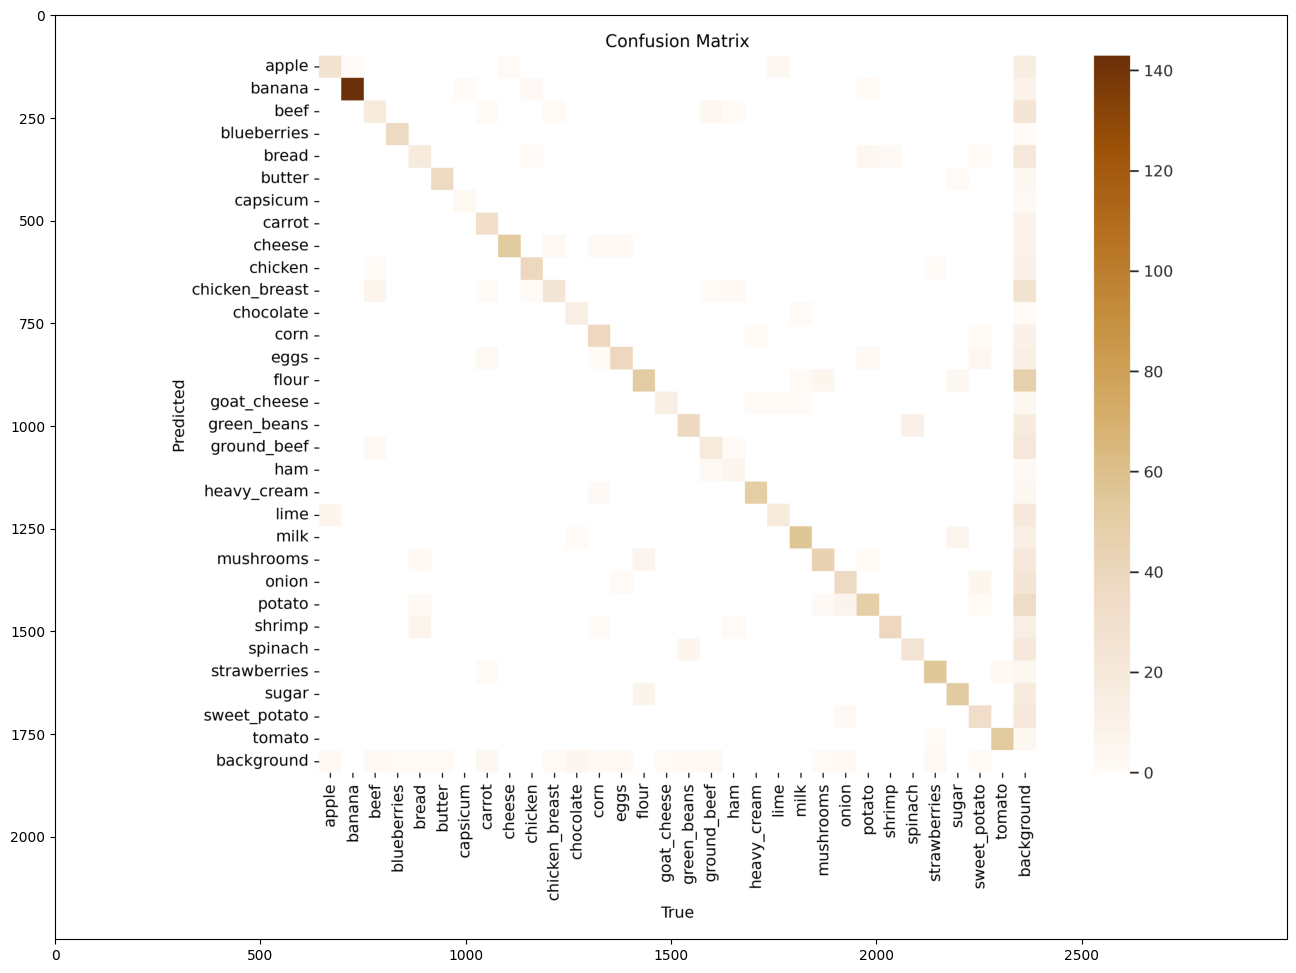

In [23]:
# Load the image
for i in list_of_metrics:
    image = cv2.imread(f'/content/runs/detect/train/{i}')

    # Create a larger figure
    plt.figure(figsize=(16, 12))

    # Display the image
    plt.imshow(image)

    # Show the plot
    plt.show()

In [ ]:
!yolo task=detect \
       mode=predict \
       model=/content/runs/detect/train/weights/best.pt \
       conf=0.25 \
       source='/content/comida2.0.v1i/valid/images/047_PNG_jpg.rf.9c701f12ecc8cbc9ddd5a7f948516272.jpg'

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3243314 parameters, 0 gradients, 9.2 GFLOPs

image 1/1 /content/comida2.0.v1i/valid/images/047_PNG_jpg.rf.9c701f12ecc8cbc9ddd5a7f948516272.jpg: 416x416 1 dumpling, 1 egg, 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
class C2f(nn.Module):
    # CSP Bottleneck with 2 convolutions
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        self.c = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, 2 * self.c, 1, 1)
        self.cv2 = Conv((2 + n) * self.c, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.ModuleList(Bottleneck(self.c, self.c, shortcut, g, k=((3, 3), (3, 3)), e=1.0) for _ in range(n))

    def forward(self, x):
        # y = list(self.cv1(x).split((self.c, self.c), 1))
        # y.extend(m(y[-1]) for m in self.m)
        # return self.cv2(torch.cat(y, 1))

        print("ook")
        x = self.cv1(x)
        x = [x, x[:, self.c:, ...]]
        x.extend(m(x[-1]) for m in self.m)
        x.pop(1)
        return self.cv2(torch.cat(x, 1))

In [ ]:
def forward(self, x):
        shape = x[0].shape  # BCHW
        for i in range(self.nl):
            x[i] = torch.cat((self.cv2[i](x[i]), self.cv3[i](x[i])), 1)
        if self.training:
            return x
        elif self.dynamic or self.shape != shape:
            self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))
            self.shape = shape

        # box, cls = torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2).split((self.reg_max * 4, self.nc), 1)
        # dbox = dist2bbox(self.dfl(box), self.anchors.unsqueeze(0), xywh=True, dim=1) * self.strides
        # y = torch.cat((dbox, cls.sigmoid()), 1)
        # return y if self.export else (y, x)

        print("ook")
        return torch.cat([xi.view(shape[0], self.no, -1) for xi in x], 2).permute(0, 2, 1)

In [ ]:
!yolo task=detect mode=export model=/content/runs/detect/train/weights/best.pt \
format=onnx simplify=True opset=13 imgsz=416

Ultralytics YOLOv8.0.238 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3243314 parameters, 0 gradients, 9.2 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 94, 3549) (6.4 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxsim>=0.4.33', 'onnxruntime'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 151.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 257.1 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.3s, installed 3 packages: ['onnx>=1.12.0', 'onnxsim>=0.4.33', 'onnxruntime']
requirements: ⚠️ Restart runtime or reru

In [ ]:
print('result of training')
tpaths2=[]
for dirname, _, filenames in os.walk('/content/runs/detect/train'):
    for filename in filenames:
        if filename[-4:]=='.png' or filename[-4:]=='.jpg':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)
print(tpaths2[0])

result of training
/content/runs/detect/train/F1_curve.png


In [ ]:
for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()

In [ ]:
print('Predict')
best_path0='/content/runs/detect/train/weights/best.pt'
source0='/content/comida2.0.v1i/valid/images'

Predict


In [ ]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths[0])

/content/comida2.0.v1i/valid/images/007_jpg.rf.bdf4efdbad0d7ce195263e3c21856a27.jpg


In [ ]:
model2 = YOLO(best_path0)
print('yolo task=detect mode=predict')

yolo task=detect mode=predict


In [ ]:
!yolo task=detect mode=predict model={best_path0} conf=0.4 source={source0}

In [ ]:
print('Result of Prediction')
results = model2.predict(source0,conf=0.4)
print(len(results))

In [ ]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

In [ ]:
class_map = {
    0: 'Maçã',
    1: 'Banana',
    2: 'Livro',
    3: 'Caixa de Cereal',
    4: 'Kochujang',
    5: 'Laranja',
    6: 'maçã',
    7: 'abacate',
    8: 'bacon',
    9: 'banana',
    10: 'carne bovina',
    11: 'pão',
    12: 'bardana',
    13: 'manteiga',
    14: 'repolho',
    15: 'milho enlatado',
    16: 'atum enlatado',
    17: 'cenoura',
    18: 'queijo',
    19: 'frango',
    20: 'pimenta em pó',
    21: 'pão de chocolate',
    22: 'canela',
    23: 'óleo de cozinha',
    24: 'milho',
    25: 'flocos de milho',
    26: 'carne de caranguejo',
    27: 'pepino',
    28: 'curry em pó',
    29: 'bolinho',
    30: 'ovo',
    31: 'bolo de peixe',
    32: 'batata frita',
    33: 'alho',
    34: 'gengibre',
    35: 'cebolinha',
    36: 'presunto',
    37: 'batata hash brown',
    38: 'cachorro-quente',
    39: 'gelo',
    40: 'ketchup',
    41: 'kimchi',
    42: 'limão',
    43: 'suco de limão',
    44: 'mandarim',
    45: 'marshmallow',
    46: 'maionese',
    47: 'leite',
    48: 'queijo muçarela',
    49: 'cogumelo',
    50: 'mostarda',
    51: 'nachos',
    52: 'macarrão',
    53: 'nutella',
    54: 'azeite',
    55: 'cebola',
    56: 'oreo',
    57: 'queijo parmesão',
    58: 'salsa',
    59: 'macarrão',
    60: 'manteiga de amendoim',
    61: 'pera',
    62: 'pimenta',
    63: 'pimenta em pó',
    64: 'picles',
    65: 'rabano em conserva',
    66: 'pimentão',
    67: 'abacaxi',
    68: 'porco',
    69: 'batata',
    70: 'ramen',
    71: 'vinho tinto',
    72: 'arroz',
    73: 'sal',
    74: 'linguiça',
    75: 'alga marinha',
    76: 'gergelim',
    77: 'óleo de gergelim',
    78: 'pasta de camarão',
    79: 'molho de soja',
    80: 'spam',
    81: 'lula',
    82: 'morango',
    83: 'açúcar',
    84: 'batata-doce',
    85: 'tofu',
    86: 'tomate',
    87: 'wasabi',
    88: 'melancia',
    89: 'creme de leite'
}

print(class_map[17])


In [ ]:
PBOX['class'] = PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX = PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

In [ ]:
def draw_box2(n0):

    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]

    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x=int(box.loc[i,'x'])
            y=int(box.loc[i,'y'])
            x2=int(box.loc[i,'x2'])
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            cv2.putText(image, f'{label}', (x, int(y-4)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,0),2)
            cv2.rectangle(image,(x,y),(x2,y2),(0,255,0),2) #green

    #plt.imshow(image)
    #plt.show()

    return image

In [ ]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    text = plt.text(0.05, 0.05, f'Slide {0}', transform=fig.transFigure, fontsize=14, color='blue')
    plt.axis('off')
    plt.close()

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        text.set_text(f'Slide {20+i}')
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000)

In [ ]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

In [ ]:
create_animation(images2)

In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

def run():

    model.predict(
        source="./35-art_15833949816299_553cc3_jpg.rf.410e480102bb96e5c1fc50cc94717b60.jpg",
        conf=0.25,
        save=True,
        show=True,
        save_crop=True
    )

if __name__ == '__main__':
    run()

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# Assuming you have a YOLO class with a 'predict' method that takes an image path
class YOLO:
    def __init__(self, model_path):
        # Initialize your YOLO model here
        # For example:
        # self.model = load_your_yolo_model(model_path)
        pass

    def predict(self, image_path):
        # Replace this with your actual prediction logic
        # Use your trained YOLO model to predict objects in the image
        # Return a list of results, each result should be a dictionary
        # For example: [{'image_path': 'path/to/image.jpg', 'prediction': 'Object detected'}, ...]
        # Make sure to use your actual YOLO model for prediction
        return [{'image_path': image_path, 'prediction': 'Object detected'}]

def take_photo_and_detect(model, filename='photo.jpg', quality=0.8):
    # JavaScript code to capture a photo from the webcam
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
    ''')

    # Display the JavaScript code for capturing a photo
    display(js)

    # Capture a photo and save it to a file
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    # Use the YOLO model to predict objects in the captured photo
    results = model.predict(filename)

    # Display the results
    for result in results:
        display(Image(filename=result['image_path']))
        print(result['prediction'])

# Instantiate the YOLO model with the correct model path
# Replace '/content/runs/detect/train/weights/best.pt' with the actual path to your trained YOLO model
yolo_model = YOLO('/content/runs/detect/train/weights/best.pt')

# Run the combined function
if __name__ == '__main__':
    take_photo_and_detect(yolo_model)
